In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import pyarrow.parquet as pq
import random
import ipywidgets as widgets
from IPython.display import display

In [2]:
def load_graph_from_parquet(parquet_path: str) -> nx.Graph:
    """Load the graph from the Parquet file."""
    graph_df = pd.read_parquet(parquet_path)
    
    G = nx.Graph()
    
    for _, row in graph_df.iterrows():
        city_from = row['city_from']
        city_to = row['city_to']
        distance = row['distance']
        
        # Add both directions to the graph
        G.add_edge(city_from, city_to, weight=distance)
    
    return G

In [3]:
def get_subgraph(graph: nx.Graph, num_nodes: int) -> nx.Graph:
    """Get a subgraph with a specified number of connected nodes."""
    # Randomly choose a starting node
    start_node = random.choice(list(graph.nodes()))
    
    # Perform a BFS to find connected nodes. Limit the search to num_nodes.
    subgraph_nodes = [start_node]
    visited = set(subgraph_nodes)
    
    while len(subgraph_nodes) < num_nodes:
        current_node = subgraph_nodes[-1]
        # Get all neighbors of the current node
        neighbors = list(graph.neighbors(current_node))
        
        # Filter out the neighbors that are already in the subgraph
        new_neighbors = [n for n in neighbors if n not in visited]
        
        # If we found new neighbors, add one randomly
        if new_neighbors:
            next_node = random.choice(new_neighbors)
            subgraph_nodes.append(next_node)
            visited.add(next_node)
    
    # Create a subgraph using the selected nodes
    subgraph = graph.subgraph(subgraph_nodes).copy()
    
    return subgraph

In [4]:
parquet_path = r"C:\Users\vikne\Documents\Master 2\Semestre 9\Intelligence artificielle\Travel-Order-Resolver\ai\path_algorithm\dataset\graph.parquet"

print("Loading graph from Parquet...")
graph = load_graph_from_parquet(parquet_path)
print("Graph loaded.")

nodes_to_include = list(graph.nodes())[:15]
subgraph = graph.subgraph(nodes_to_include).copy()
print("Subgraph selected.")

Loading graph from Parquet...
Graph loaded.
Subgraph selected.


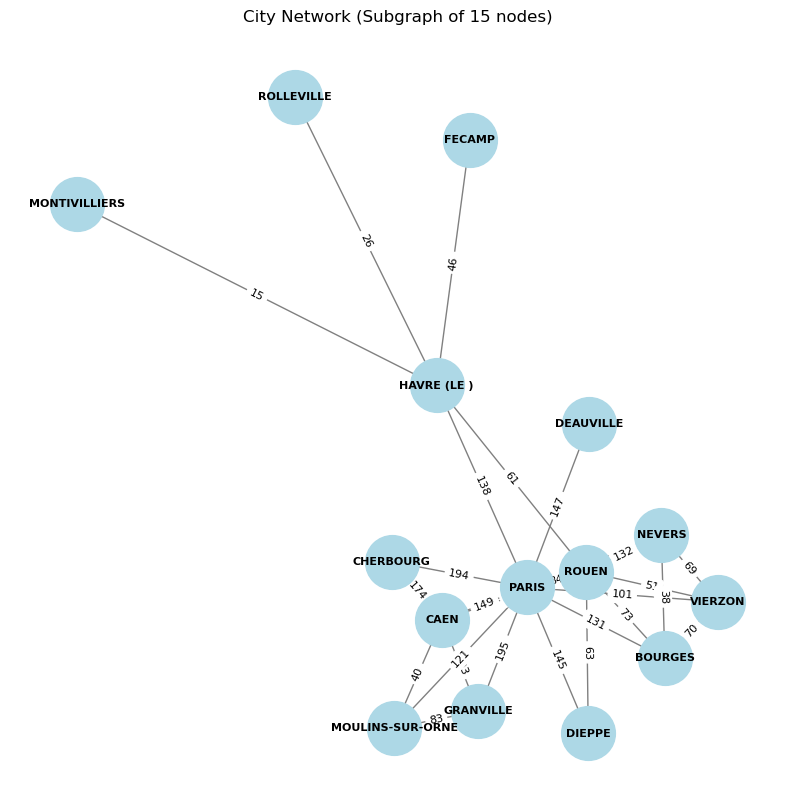

In [5]:
def visualize_graph(graph: nx.Graph) -> None:
    """Visualize the graph using matplotlib with reduced size."""
    plt.figure(figsize=(10, 10))
    
    pos = nx.spring_layout(graph, seed=42)
    plt.title(f"City Network (Subgraph of {len(graph.nodes())} nodes)", fontsize=12)

    nx.draw(graph, pos, with_labels=True, node_size=1500, node_color='lightblue', font_size=8, font_weight='bold', edge_color='gray')

    edge_labels = nx.get_edge_attributes(graph, 'weight')
    nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels, font_size=8)

    plt.show()

visualize_graph(subgraph)

In [6]:
def find_shortest_path(graph: nx.Graph, start: str, end: str) -> dict:
    """Find the shortest path using Dijkstra's algorithm."""
    try:
        # Using NetworkX's built-in function to find the shortest path
        length, path = nx.single_source_dijkstra(graph, source=start, target=end)
        return {
            'path': path,
            'total_duration': length
        }
    except nx.NetworkXNoPath:
        return {
            'path': ["No path found"],
            'total_duration': None
        }

In [7]:
import ipywidgets as widgets
from IPython.display import display

# Create input fields and button for the interface
start_city_input = widgets.Text(value='', placeholder='Enter start city', description='Start City:', disabled=False)
end_city_input = widgets.Text(value='', placeholder='Enter end city', description='End City:', disabled=False)
output = widgets.Output()


def on_button_click(b):
    with output:
        start_city = start_city_input.value
        end_city = end_city_input.value
        
        if start_city and end_city:
            # Find the shortest path
            result = find_shortest_path(graph, start_city, end_city)
            
            # Display result
            if result['path'][0] == "No path found":
                print(f"No path found between {start_city} and {end_city}.")
            else:
                print(f"Shortest path from {start_city} to {end_city}: {result['path']}")
                print(f"Total duration: {result['total_duration']} minutes")
                
                # Extract the subgraph for the path
                path_subgraph = graph.subgraph(result['path']).copy()
                
                # Visualize the path subgraph
                plt.figure(figsize=(6, 6))
                pos = nx.spring_layout(path_subgraph, seed=42)
                plt.title(f"Shortest Path: {start_city} to {end_city}")
                nx.draw(path_subgraph, pos, with_labels=True, node_size=3000, node_color='lightgreen', font_size=10, font_weight='bold', edge_color='gray')
                edge_labels = nx.get_edge_attributes(path_subgraph, 'weight')
                nx.draw_networkx_edge_labels(path_subgraph, pos, edge_labels=edge_labels)
                plt.show()
        else:
            print("Please enter both starting and ending cities.")

# Button to trigger the process
find_button = widgets.Button(description="Find Shortest Path")
find_button.on_click(on_button_click)

# Display the interface with the button, inputs, and output area
display(start_city_input, end_city_input, find_button, output)

Text(value='', description='Start City:', placeholder='Enter start city')

Text(value='', description='End City:', placeholder='Enter end city')

Button(description='Find Shortest Path', style=ButtonStyle())

Output()